## Negative Log-likelihood (NLL) approach per subject

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import seaborn as sns
sns.set(style='white', context='talk', palette='colorblind')

from behavior_model_fitting.helpers.policy import softmax, pick_action 
from behavior_model_fitting.tasks.BernoulliBandit import BernoulliBandit

In [6]:
data=pd.read_pickle('../data/BernoulliBanditData.pickel')#, converters={'outcomes':converter})

### compute NLL per subj per paramter

In [197]:
subj = 0
lr = 0.001
beta = 0.1
outcome = data.outcomes[subj]
choice = data.actions[subj].astype('int')
action = data.actions[subj].astype('int')
q_init = torch.as_tensor(data.true_Qinit[subj])

In [255]:
def nll_per_model_per_subject(outcomes, q, lr, beta, choice, ntrials=1000):
    nll = 0.
    for trial in range(ntrials):
        a_t = choice[trial]
        nll += -(q[a_t]*beta - np.log(np.exp(q*beta).sum()))
        r_t = outcomes[trial][a_t]
        q[a_t] = q[a_t] + lr*(r_t-q[a_t])
        
    return nll

In [200]:
NLL = nll_per_model_per_subject(outcome, q_init, lr, beta, action)

### compute NLL per subj per model across parameters

In [185]:
from matplotlib.colors import LogNorm, SymLogNorm

In [253]:
nparams = 10
nsubj = 10

betas = np.linspace(0.01, 10, nparams)
lrs = np.linspace(0.001, 0.1, nparams)
NLLS = np.zeros((nsubj, nparams, nparams))

In [256]:
for subj in range(nsubj):
    for ix, lr in enumerate(lrs): 
        for iy, beta in enumerate(betas):
            NLLS[subj, ix, iy] = nll_per_model_per_subject(data.outcomes[subj],torch.tensor(data.true_Qinit[subj]), lr, beta, data.actions[subj].astype('int'))

In [279]:
SUBJ=8
best_lr_idx, best_beta_idx =np.unravel_index(NLLS[SUBJ].argmin(), NLLS[SUBJ].shape)
print('true parameters: lr {}, beta {}'.format(data.loc[SUBJ].true_lr, data.loc[SUBJ].true_beta))
print('fit parameters: lr {}, beta {}'.format(lrs[best_beta_idx], betas[best_beta_idx]))

true parameters: lr 0.0780375183440352, beta 9.636990977405283
fit parameters: lr 0.08900000000000001, beta 8.89


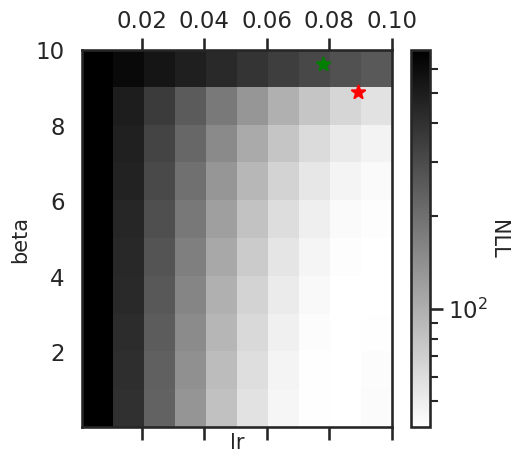

In [280]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
im = ax.matshow(NLLS[SUBJ], cmap='gray_r', extent=[0.001,0.1,0.001,10], aspect='auto',norm=LogNorm(vmin=NLLS[SUBJ].min(), vmax=NLLS[SUBJ].max()))
ax.scatter(data.loc[SUBJ].true_lr, data.loc[SUBJ].true_beta, c='green', marker='*', s=100)
ax.scatter(lrs[best_beta_idx], betas[best_beta_idx], c='red', marker='*', s=100)
ax.set_ylabel(ylabel='beta', fontsize=15)
ax.set_xlabel(xlabel='lr', fontsize=15)
cbar=plt.colorbar(mappable=im, ax=ax)
cbar.set_label('NLL', rotation=270, fontsize=15, labelpad=15)
plt.show()

### compute NLL per subj across parameters (speed-up)

In [220]:
q=torch.tensor([[0.5, 0.5],[0.5, 0.5],[0.5, 0.5]])

In [221]:
lr = torch.tensor([0.1, 0.5, 2]).reshape(-1,1)
beta= torch.tensor([1, 2, 3]).reshape(-1,1)

In [249]:
def nll_per_subject(outcomes, qq, lr, beta, choice, ntrials=1000):
    nll = 0.
    for trial in range(ntrials):
        a_t = choice[trial]
        nll += -(qq[:, a_t].reshape(-1,1)*beta - np.log(np.exp(qq*beta).sum(1)).reshape(-1,1))
        r_t = outcomes[trial][a_t]
        c = (qq[:, a_t].reshape(-1,1)+(r_t-q[:, a_t]).reshape(-1,1)*lr).reshape(len(lr))
        
    return nll

In [252]:
nll_per_subject(outcome, q, lr, beta, action)

tensor([[ 382.1781],
        [ 182.5676],
        [1539.0000]])